In [1]:
import torch
from feature_extractors import feature_extractor
import sys
%load_ext autoreload
%autoreload 2

In [2]:
sys.modules["bow.feature_extractor"] = feature_extractor

In [3]:
ckp = torch.load("ckpts/cnn.ckpt", map_location="cpu")

In [4]:
state_keys = list(ckp["state_dict"].keys())

In [6]:
for _, k in enumerate(state_keys):
    newkey = f"model.{k}"
    ckp["state_dict"][newkey] = ckp["state_dict"].pop(k)

In [7]:
from clr_gat import CLRGAT

In [8]:
from omegaconf import OmegaConf
OmegaConf.register_new_resolver("uuid", lambda : "123")

In [9]:
ckp["hyper_parameters"].pop("inner_lr")

0.001

In [10]:
ckp["hyper_parameters"]["mpnn_dev"] = "cpu"
model = CLRGAT(**ckp["hyper_parameters"])

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'feature_extractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['feature_extractor'])`.
  rank_zero_warn(


MultiHeadDotProduct


/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [23]:
model.load_state_dict(ckp["state_dict"])

<All keys matched successfully>

In [ ]:
from dataloaders import UnlabelledDataset, UnlabelledDataModule

In [ ]:
dm = UnlabelledDataModule(**OmegaConf.load("configs/local/edge.yml")["data"], split="train")
dm.setup()

In [ ]:
dlt = dm.train_dataloader()

In [ ]:
xs = next(iter(dlt))

In [11]:
o,v = xs["origs"], xs["views"]

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
import einops
sns.set_theme()

In [15]:
o = einops.rearrange(o, "b 1 c h w -> b c h w")

EinopsError:  Error while processing rearrange-reduction pattern "b 1 c h w -> b c h w".
 Input tensor shape: torch.Size([64, 3, 84, 84]). Additional info: {}.
 Expected 5 dimensions, got 4

In [16]:
v = einops.rearrange(v, "b q c h w -> (b q) c h w")

EinopsError:  Error while processing rearrange-reduction pattern "b q c h w -> (b q) c h w".
 Input tensor shape: torch.Size([192, 3, 84, 84]). Additional info: {}.
 Expected 5 dimensions, got 4

In [17]:
y_query = torch.arange(64).unsqueeze(
            0).unsqueeze(2)  # batch and shot dim
y_query = y_query.repeat(1, 1, 3)
y_query = y_query.view(1, -1)

y_support = torch.arange(64).unsqueeze(
    0).unsqueeze(2)  # batch and shot dim
y_support = y_support.repeat(1, 1, 1)
y_support = y_support.view(1, -1)

In [18]:
y = torch.cat([y_support, y_query], dim=1).squeeze(0)

In [19]:
feats = model.backbone(torch.cat([o, v]))

In [20]:
feats = feats.flatten(1)

In [21]:
pfeats_tsne = TSNE().fit_transform(feats.cpu().detach().numpy())

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [22]:
pfeats_umap = umap.UMAP().fit_transform(feats.cpu().detach().numpy())

In [23]:
sns.set_theme()

<AxesSubplot:>

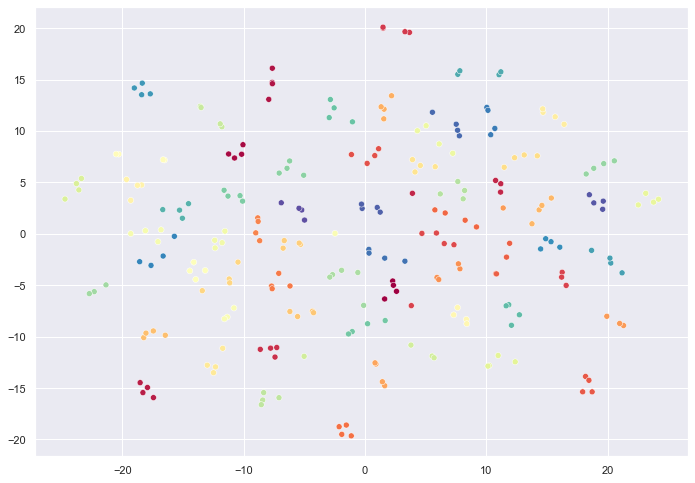

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats_tsne[:, 0], y=pfeats_tsne[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=None)

<AxesSubplot:>

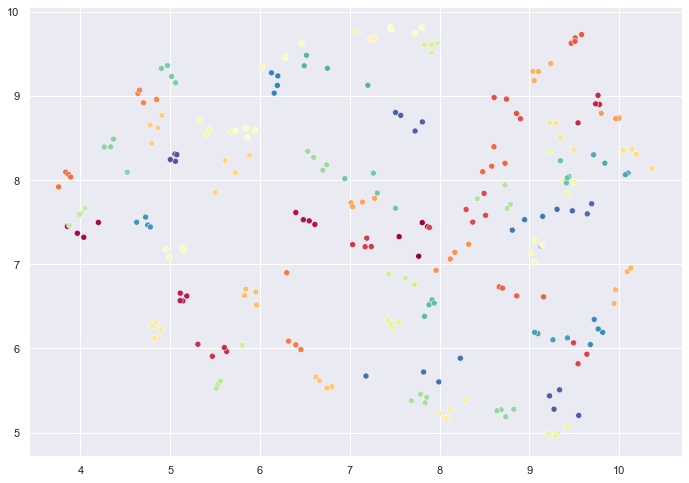

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats_umap[:, 0], y=pfeats_umap[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=None)

In [27]:
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)

In [28]:
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

In [29]:
gfeats_tsne = TSNE().fit_transform(feats.cpu().detach().numpy())

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [30]:
gfeats_umap = umap.UMAP().fit_transform(feats.cpu().detach().numpy())

<AxesSubplot:>

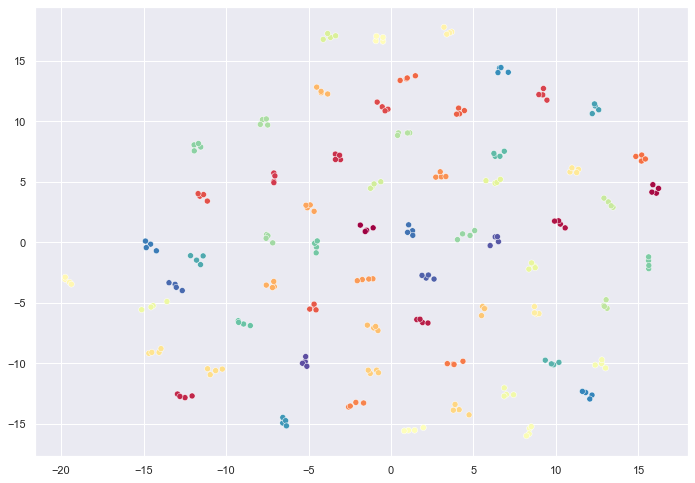

In [31]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=gfeats_tsne[:, 0], y=gfeats_tsne[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=None)

<AxesSubplot:>

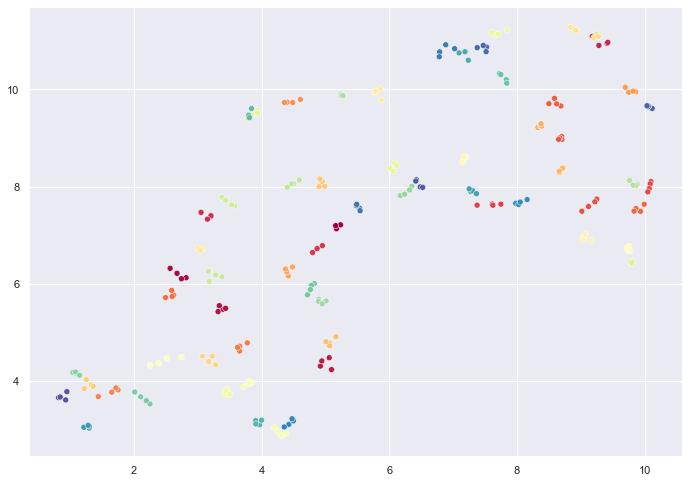

In [32]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=gfeats_umap[:, 0], y=gfeats_umap[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=None)

In [9]:
from dataloaders import get_episode_loader

In [10]:
dl = get_episode_loader("miniimagenet", "../data", 5, 5, 15, 1,"train",)

Supervised data loader for miniimagenet:train.


In [11]:
xs = next(iter(dl))

In [12]:
x = xs["train"][0].squeeze(0)
y = xs["train"][1].squeeze(0)

In [37]:
x.shape, y.shape

(torch.Size([25, 3, 84, 84]), torch.Size([25]))

In [38]:
feats = model.backbone(x).flatten(1)

In [44]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())

<AxesSubplot:>

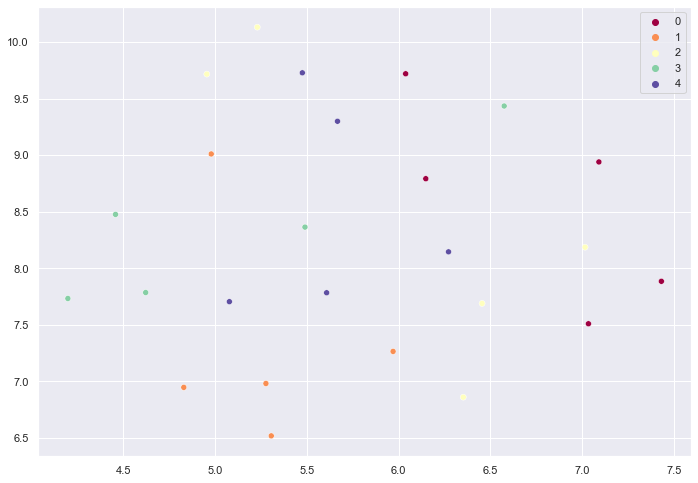

In [45]:
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

In [46]:
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

In [47]:
gfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())

<AxesSubplot:>

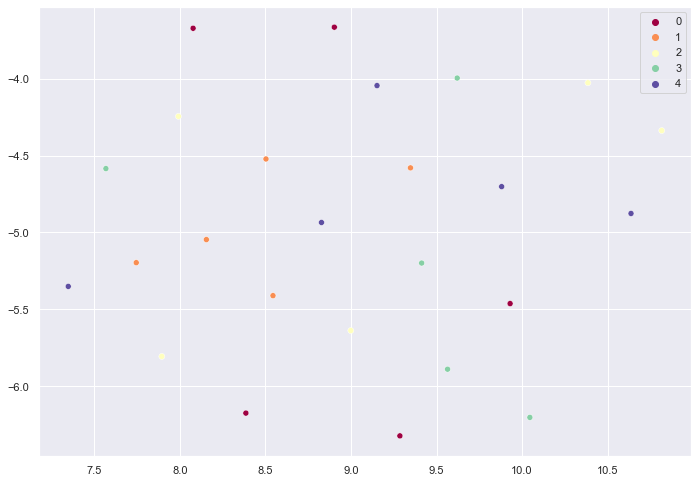

In [48]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=gfeats[:, 0], y=gfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

In [49]:
x = xs["test"][0].squeeze(0)
y = xs["test"][1].squeeze(0)

In [50]:
x.shape, y.shape

(torch.Size([75, 3, 84, 84]), torch.Size([75]))

In [51]:
feats = model.backbone(x).flatten(1)

In [52]:
pfeats = TSNE().fit_transform(feats.cpu().detach().numpy())

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

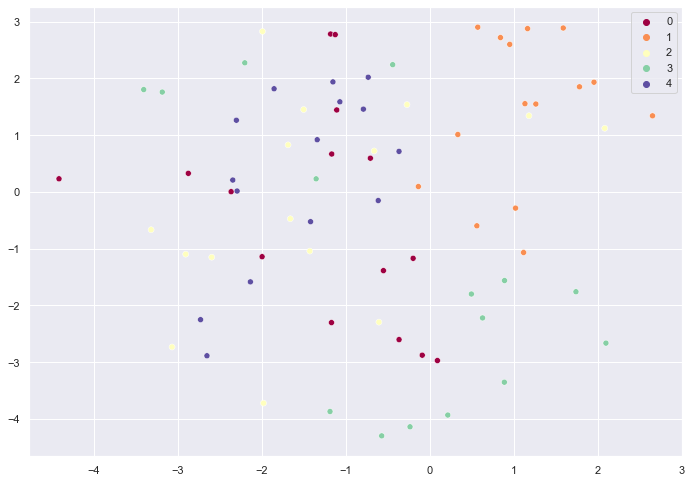

In [53]:
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

In [54]:
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

In [55]:
gfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())

<AxesSubplot:>

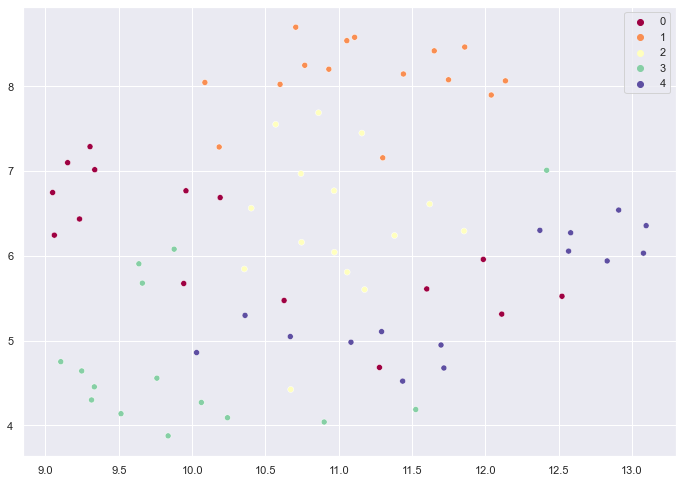

In [56]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=gfeats[:, 0], y=gfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

In [57]:
x = torch.cat([xs["train"][0], xs["test"][0]], dim=1).squeeze(0)
y = torch.cat([xs["train"][1], xs["test"][1]], dim=1).squeeze(0)

In [58]:
x.shape

torch.Size([100, 3, 84, 84])

In [59]:
feats = model.backbone(x).flatten(1)
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

In [60]:
gfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())

<AxesSubplot:>

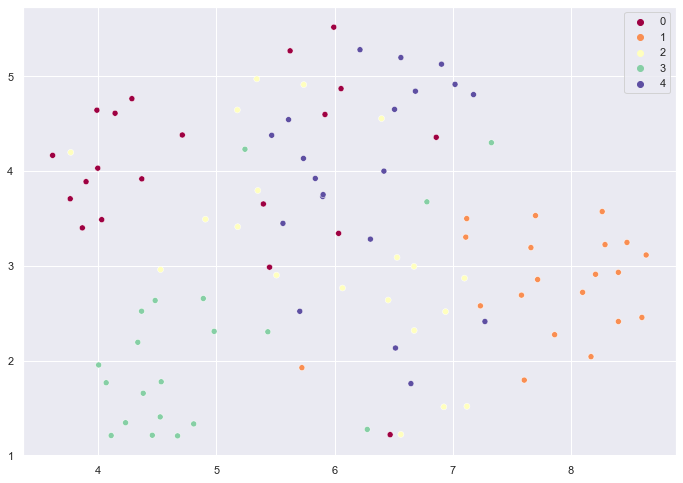

In [61]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=gfeats[:, 0], y=gfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

<AxesSubplot:>

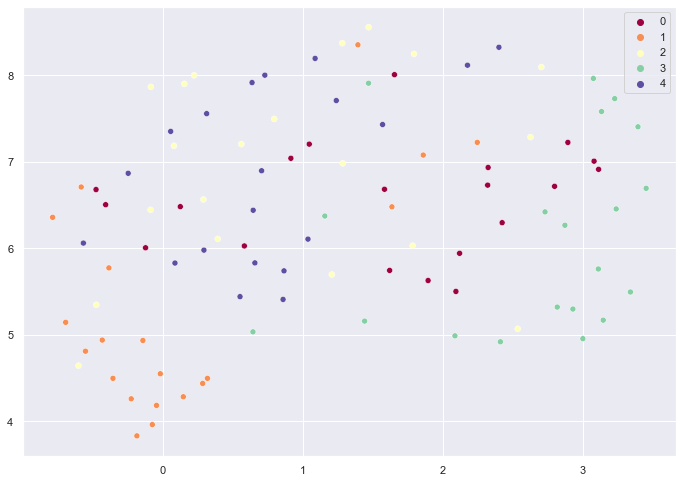

In [62]:
feats = model.backbone(x).flatten(1)
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

## trying with val split

In [10]:
dl = get_episode_loader("miniimagenet", "../data", 5, 5, 15, 1, "val")

Supervised data loader for miniimagenet:val.


In [11]:
idl = iter(dl)

In [13]:
xs = next(idl)

In [14]:
x = torch.cat([xs["train"][0], xs["test"][0]], dim=1).squeeze(0)
y = torch.cat([xs["train"][1], xs["test"][1]], dim=1).squeeze(0)

**first with supp + query together**

In [15]:
feats = model.backbone(x).flatten(1)
cnn_feats = feats.detach().clone()
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

<AxesSubplot:>

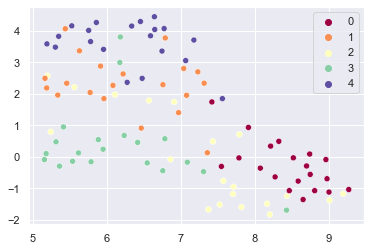

In [16]:
pfeats = umap.UMAP().fit_transform(cnn_feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

<AxesSubplot:>

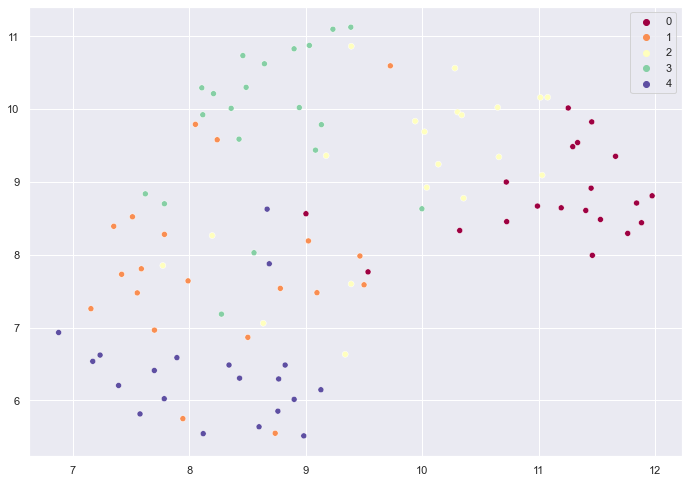

In [17]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

## plots with a test task

In [11]:
from dataloaders import get_episode_loader

In [12]:
dl = get_episode_loader("miniimagenet", "../data", 5, 5, 15, 1, "test")

Supervised data loader for miniimagenet:test.


In [13]:
idl = iter(dl)

In [14]:
xs = next(idl)

In [13]:
x = torch.cat([xs["train"][0], xs["test"][0]], dim=1).squeeze(0)
y = torch.cat([xs["train"][1], xs["test"][1]], dim=1).squeeze(0)

In [22]:
feats = model.backbone(x).flatten(1)
cnn_feats = feats.detach().clone()
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

<AxesSubplot:>

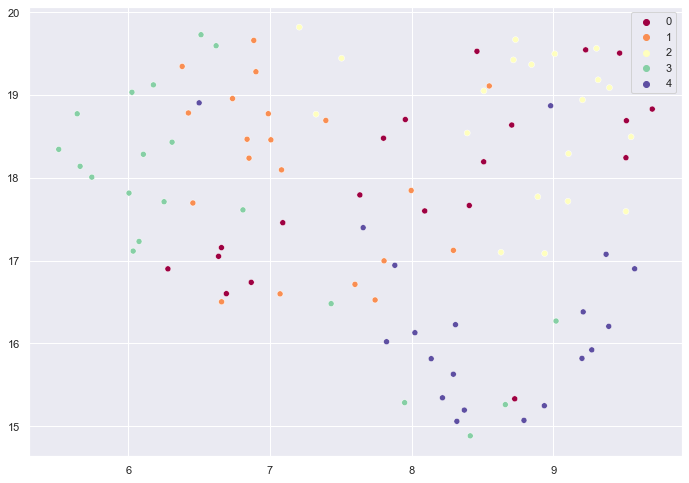

In [23]:
pfeats = umap.UMAP().fit_transform(cnn_feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

<AxesSubplot:>

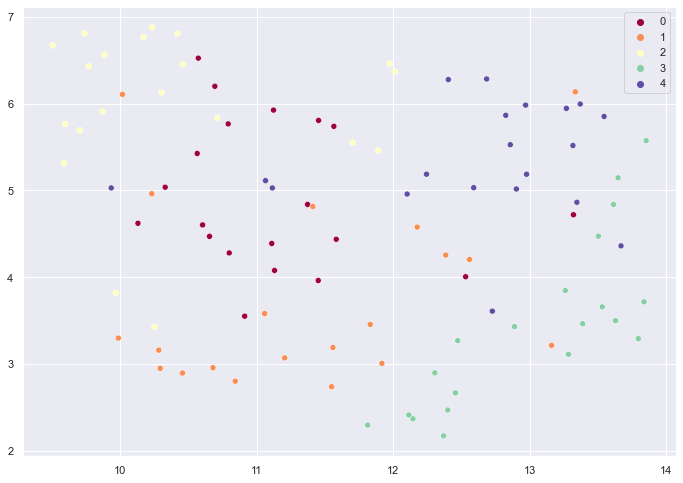

In [24]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

## With finetuning on test task

In [25]:
model.supervised_finetuning(xs, freeze_backbone=True)

  0%|          | 0/15 [00:00<?, ?it/s]

(tensor(1.3025, grad_fn=<NllLossBackward0>), 0.5066666603088379)

In [26]:
feats = model.backbone(x).flatten(1)
cnn_feats = feats.detach().clone()
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

<AxesSubplot:>

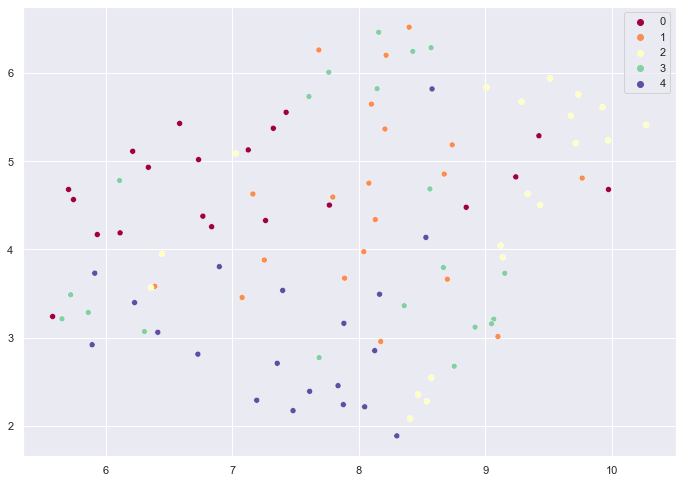

In [27]:
pfeats = umap.UMAP().fit_transform(cnn_feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

<AxesSubplot:>

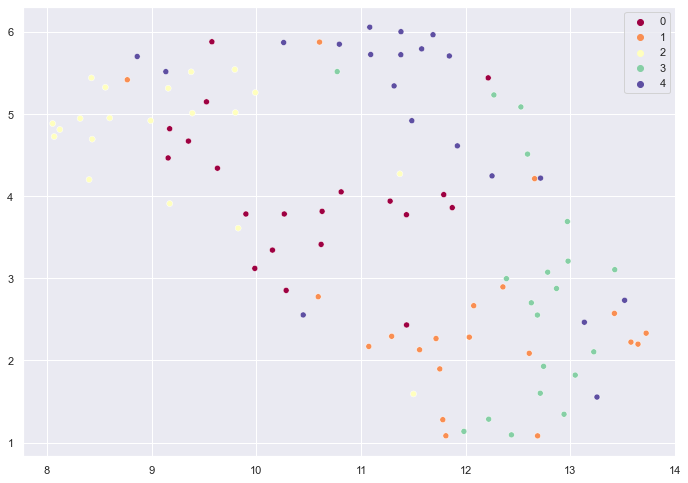

In [28]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

In [29]:
model.supervised_finetuning(xs, freeze_backbone=False)

  0%|          | 0/15 [00:00<?, ?it/s]

(tensor(2.6752, grad_fn=<NllLossBackward0>), 0.3199999928474426)

In [30]:
feats = model.backbone(x).flatten(1)
cnn_feats = feats.detach().clone()
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

<AxesSubplot:>

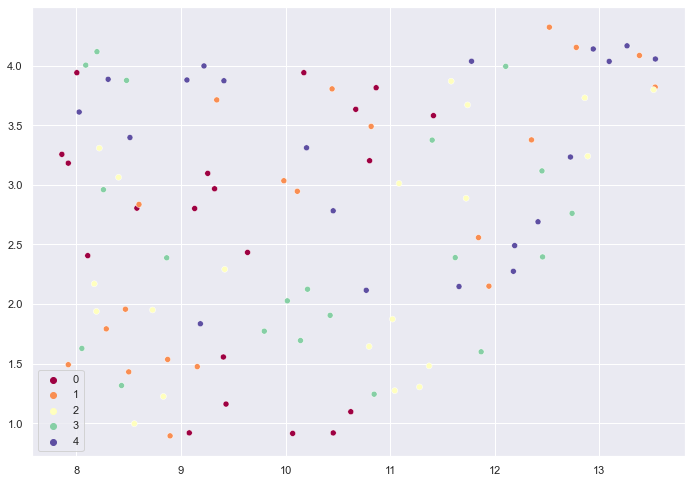

In [31]:
pfeats = umap.UMAP().fit_transform(cnn_feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

<AxesSubplot:>

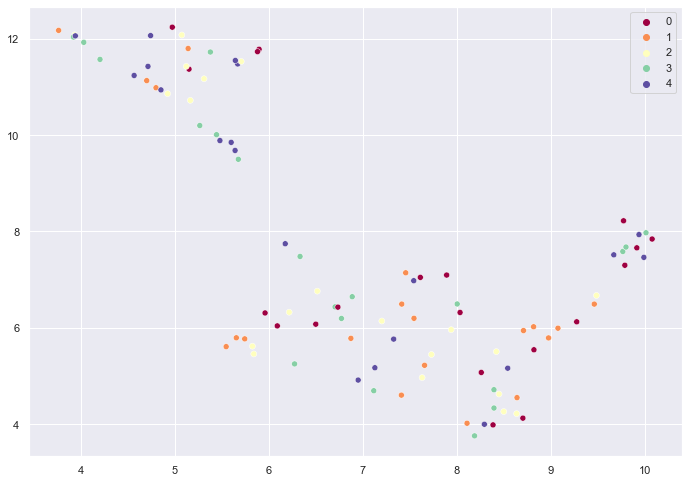

In [32]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.cpu().numpy(), palette="Spectral", legend=True)

# Proto MAML fine tuning with supconloss

In [15]:
xs = next(idl)

In [16]:
model.ft_freeze_backbone = True

In [17]:
model.sup_finetune_epochs = 10

In [18]:
model.eval();

In [19]:
model.sup_finetune_lr = model.lr

In [20]:
loss, acc, z = model.tmp_maml(xs, None)
loss, acc

(tensor(1.5710, grad_fn=<NllLossBackward0>), tensor(0.2400))

In [36]:
feats = model.backbone(xs["train"][0].squeeze(0)).flatten(1)
cnn_feats = feats.detach().clone()
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

In [37]:
xs["train"][1].shape, xs["train"][0].shape

(torch.Size([1, 25]), torch.Size([1, 25, 3, 84, 84]))

<AxesSubplot:>

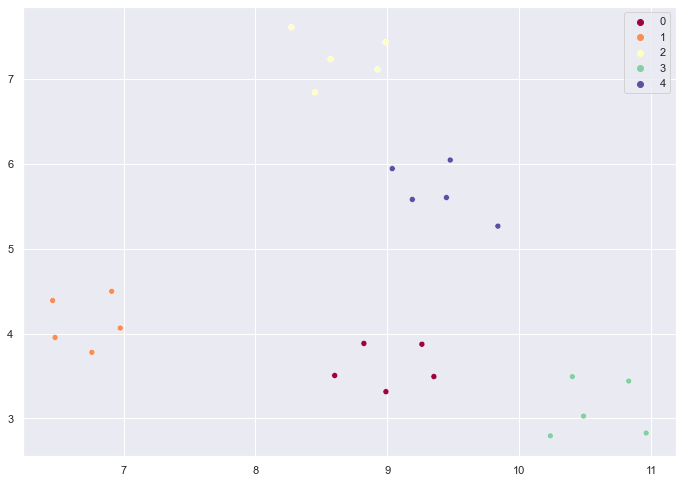

In [38]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=xs["train"][1].squeeze(0).cpu().numpy(), palette="Spectral", legend=True)

In [39]:
feats = model.backbone(xs["test"][0].squeeze(0)).flatten(1)
cnn_feats = feats.detach().clone()
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

<AxesSubplot:>

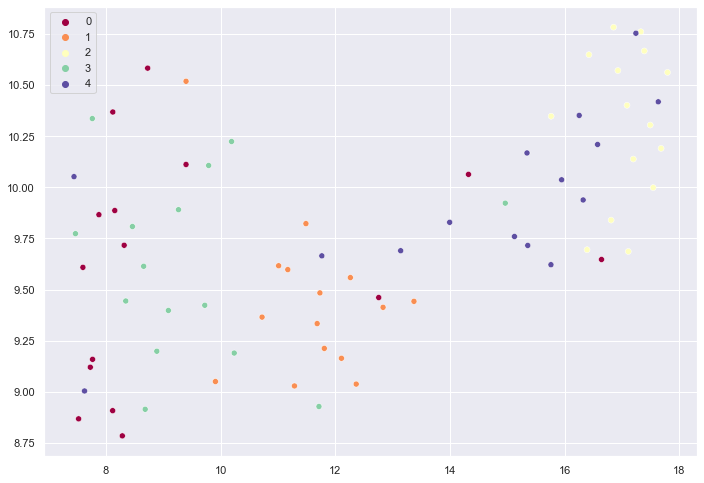

In [40]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=xs["test"][1].squeeze(0).cpu().numpy(), palette="Spectral", legend=True)

In [22]:
x = torch.cat([xs["train"][0], xs["test"][0]], dim=1).squeeze(0)
y = torch.cat([xs["train"][1], xs["test"][1]], dim=1).squeeze(0)

In [42]:
feats = model.backbone(x).flatten(1)
cnn_feats = feats.detach().clone()
edge_attr, edge_index, feats = model.graph_generator.get_graph(feats)
_, (feats,) = model.gnn(feats, edge_index, edge_attr, ckp["hyper_parameters"]["mpnn_opts"]["output_train_gnn"])

<AxesSubplot:>

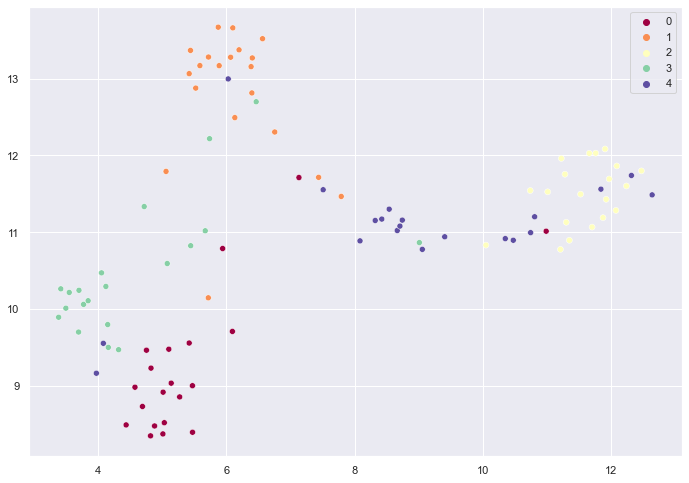

In [43]:
pfeats = umap.UMAP().fit_transform(feats.cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.squeeze(0).cpu().numpy(), palette="Spectral", legend=True)

<AxesSubplot:>

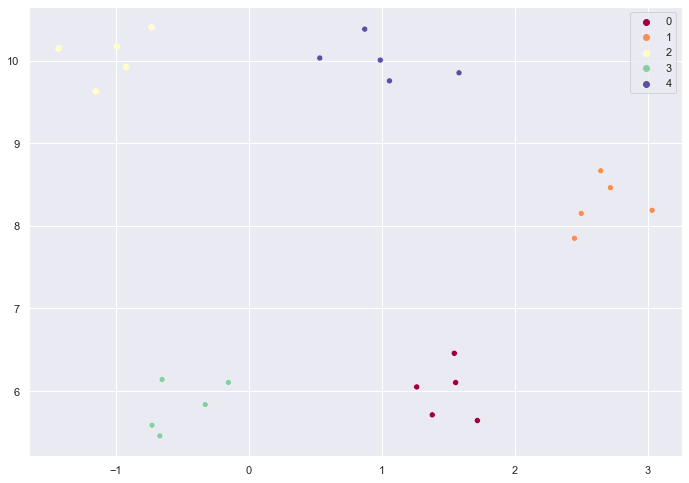

In [45]:
pfeats = umap.UMAP().fit_transform(z[0].cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=xs["train"][1].squeeze(0).cpu().numpy(), palette="Spectral", legend=True)

<AxesSubplot:>

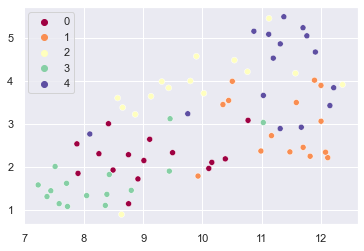

In [23]:
pfeats = umap.UMAP().fit_transform(z[1].cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=xs["test"][1].squeeze(0).cpu().numpy(), palette="Spectral", legend=True)

<AxesSubplot:>

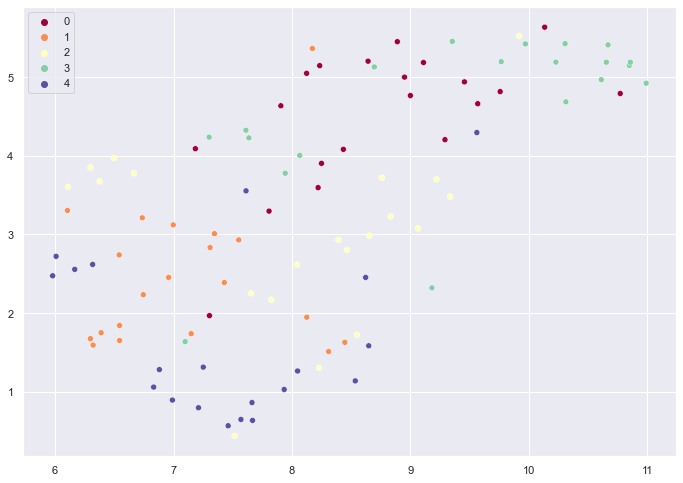

In [24]:
pfeats = umap.UMAP().fit_transform(torch.cat(z).cpu().detach().numpy())
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.squeeze(0).cpu().numpy(), palette="Spectral", legend=True)

## Proto analysis

In [61]:
z_supp, z_query = feats.split([25, 75])

In [62]:
z_proto = z_supp.view(5, 5, -1).mean(1)

In [63]:
z_proto.shape

torch.Size([5, 1600])

In [64]:
combined = torch.cat([z_proto, z_query])

In [65]:
proto_labels = torch.unique(y)

In [66]:
labels = torch.cat([proto_labels, y[25:]])

In [67]:
protofeats = TSNE().fit_transform(combined.cpu().detach().numpy())

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

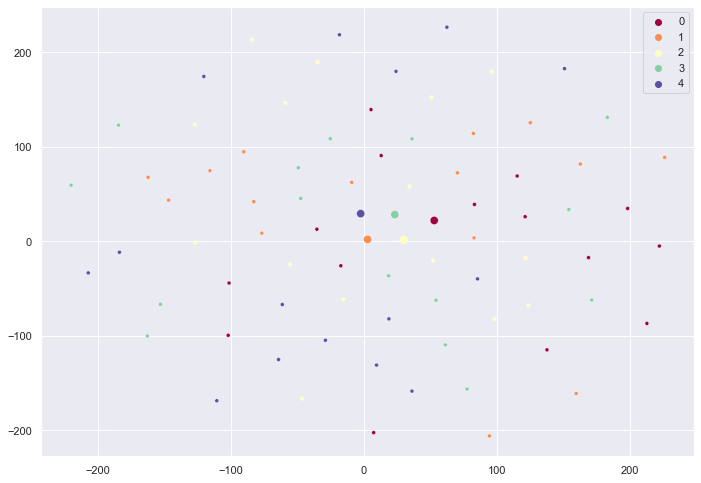

In [68]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=protofeats[:, 0], y=protofeats[:, 1], hue=labels.cpu().numpy(), palette="Spectral", legend=True,s = [65]*5 + [15]*75 )

In [105]:
model.supervised_finetuning(xs,)

  0%|          | 0/15 [00:00<?, ?it/s]

(tensor(58.0244, grad_fn=<NllLossBackward0>), 0.30666667222976685)

In [110]:
_,_,(feats,) = model(x)

In [109]:
pfeats = TSNE().fit_transform(feats.cpu().detach().numpy())

/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ojas/miniforge3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

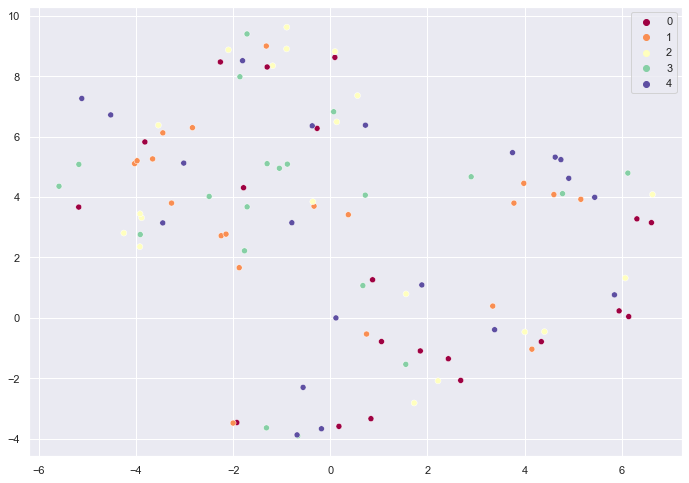

In [108]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x=pfeats[:, 0], y=pfeats[:, 1], hue=y.numpy(), palette="Spectral", legend=True,)